In [38]:
### Author: Wouter
### Date: 28.04.2023
### Datasets: Single cell RNA-seq from TF-seq EXP12-13
### Goal: Calculate differential expression

library(Seurat)
library(tidyverse)
library(edgeR)
library(ggplot2)

source("functions-combinations.R")
source("functions-diffexp.R")
source("way_color.R")

In [12]:
seu <- read_rds("seu.rds")
diffexp_folder <- "./"
seu_diffexps <- read_rds("seu_diffexps.rds")

[[1]]
[1] "Pparg" "Runx2"

[[2]]
[1] "Cebpa" "Pparg"

[[3]]
[1] "Cebpa" "Mycn" 

[[4]]
[1] "Cebpa" "Myog" 

[[5]]
[1] "Mycn" "Myog"

[[6]]
[1] "Mycn"  "Runx2"

[[7]]
[1] "Mycn"  "Pparg"

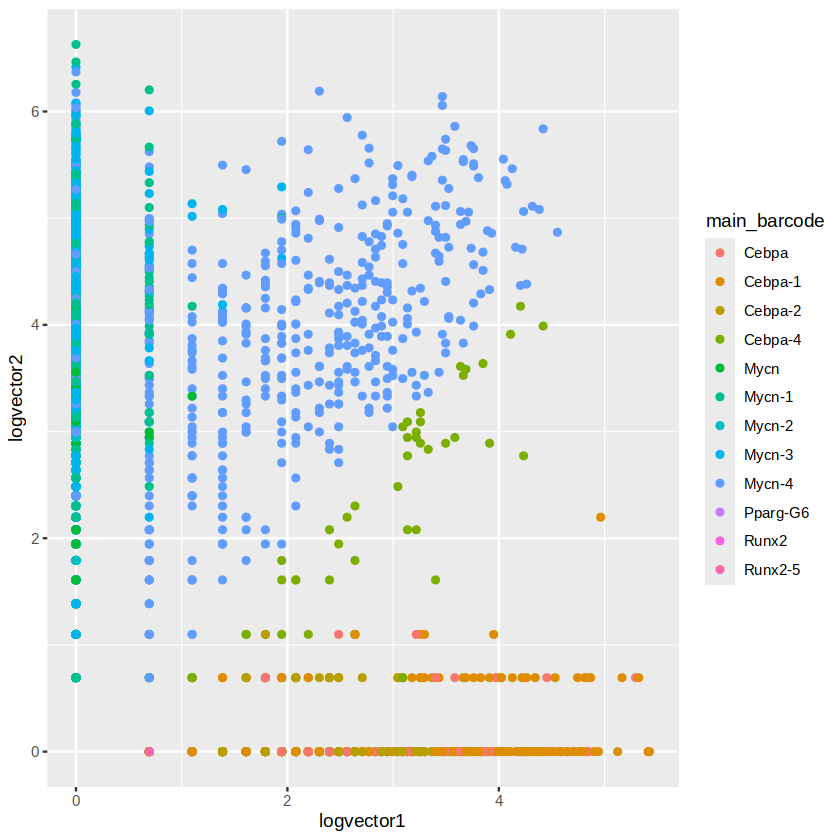

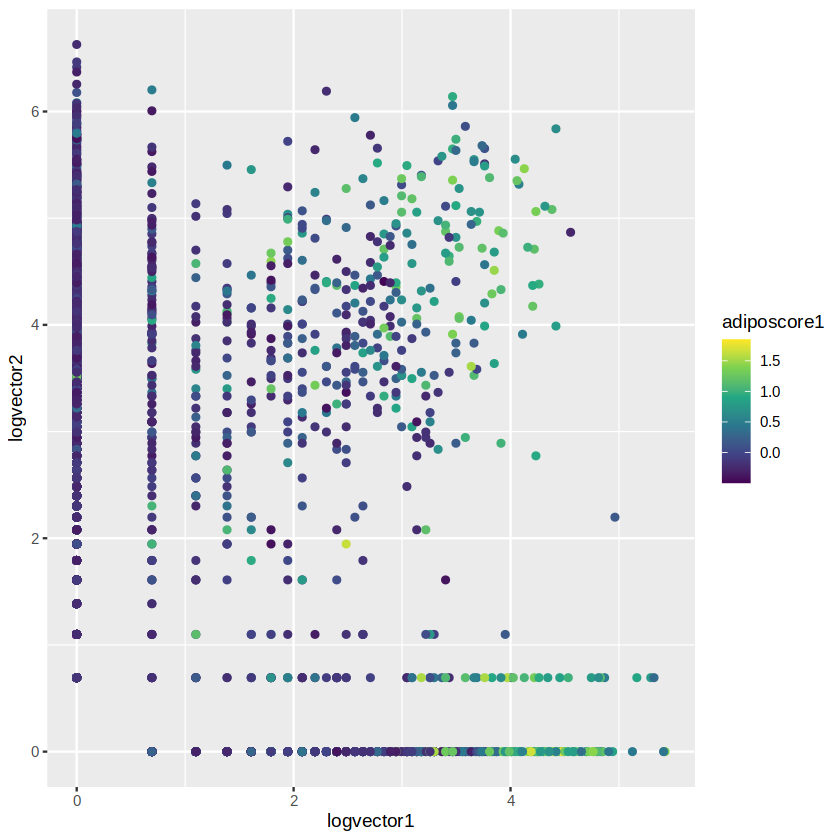

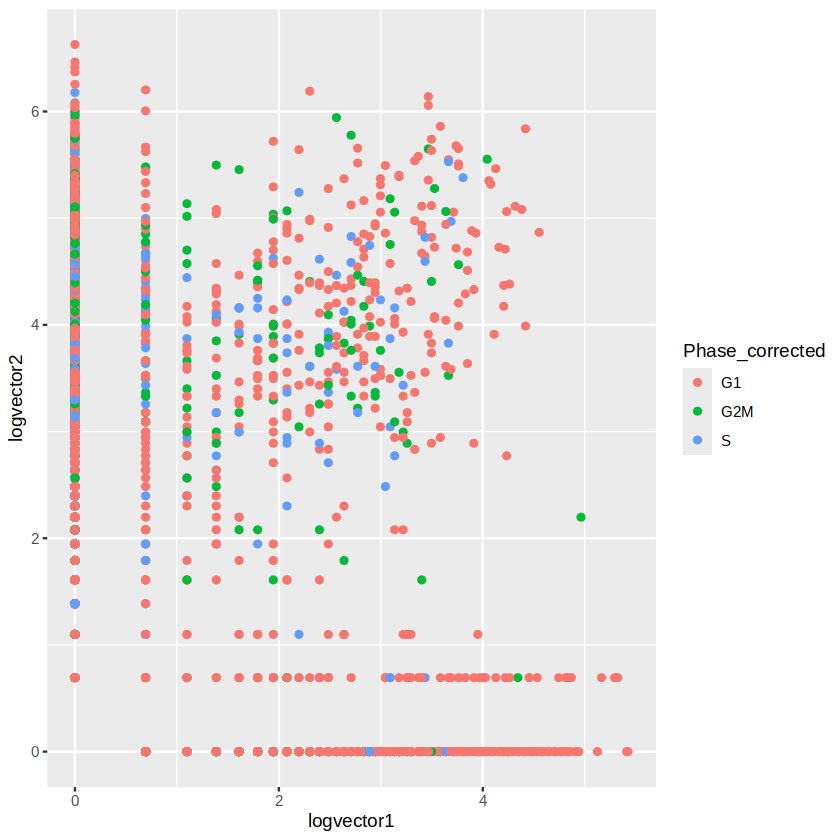

In [23]:
## Look at diffexp of single combination
plot_folder <- file.path(getwd(), "output")
dir.create(plot_folder, showWarnings = FALSE, recursive = TRUE)

heatmap_folder <- file.path(getwd(), "singletf_interaction", "heatmaps")
dir.create(heatmap_folder, showWarnings = FALSE, recursive = TRUE)

theme_heatmap <- function(plot, combination, legend = TRUE){
  plot <- plot +
    coord_fixed() + 
    theme_minimal() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggtitle(paste0(toupper(combination[[1]]), "+", toupper(combination[[2]]))) +
    theme(legend.position = "none") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    theme_classic() +
    theme(
      title = element_text(size = 8),
      axis.text = element_text(size = 7),
      axis.title = element_text(size = 8),
    )
  if (!legend) {
    plot <- plot + theme(legend.position="none")
  }
  plot
}

## Plot dosages and barcodes
combinations

combination_ix <- 3
combination <- combinations[[combination_ix]]
seu_diffexp <- seu_diffexps[[combination_ix]]

plotdata <- seu_diffexp@meta.data
plotdata$main_barcode <- rownames(seu_diffexp@assays$bcumi@counts)[apply(seu_diffexp@assays$bcumi@counts, 2, which.max)]

ggplot(plotdata, aes(logvector1, logvector2)) + geom_point(aes(colour = main_barcode))
ggplot(plotdata, aes(logvector1, logvector2)) + geom_point(aes(colour = adiposcore1)) + scale_colour_viridis_c()
ggplot(plotdata, aes(logvector1, logvector2)) + geom_point(aes(colour = Phase_corrected))


In [21]:


## 
n_cells_cutoff <- 0


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


[1] "/srv/data/wouters/projects/tfseq/code/ZZ_Combinations/singletf_interaction/heatmaps/adiposcore.png"

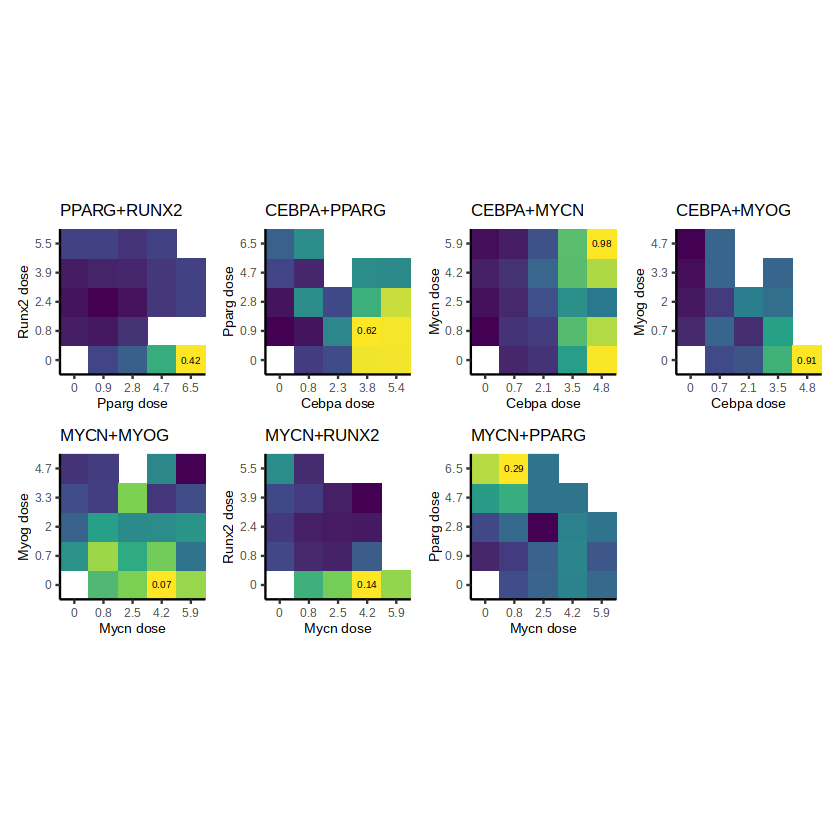

In [28]:


## ADIPOSCORE
# dose binned
plots <- map2(combinations, seu_diffexps, function(combination, seu_diffexp) {
  col <- sym("adiposcore1")
  
  seu_diffexp <- seu_diffexp[, seu_diffexp$Phase_corrected == "G1"]
  
  summarized <- seu_diffexp@meta.data %>% group_by(bin1, bin2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  summarized$score[summarized$n <= 2] = mean(summarized$score) # those with not enough cells -> set to mean
  title <- paste0(toupper(combination[[2]]), "+", toupper(combination[[1]]))
  
  plot <- ggplot(summarized, aes(bin1, bin2)) + 
    geom_tile(aes(fill = score)) +
    geom_text(aes(label = round(score, 2)), data = summarized %>% filter(score == max(score)), size = 2) +
    scale_fill_viridis_c(na.value = "#33333333") +
    scale_x_discrete(name = paste0(combination[[1]], " dose"), labels = deframe(seu_diffexp@misc$bin_info1 %>% select(name, label)), expand = c(0, 0)) + 
    scale_y_discrete(name = paste0(combination[[2]], " dose"), labels = deframe(seu_diffexp@misc$bin_info2 %>% select(name, label)), expand = c(0, 0)) +
    ggtitle(title)
  plot %>% theme_heatmap(combination, legend = F)
})
plot <- c(plots) %>% patchwork::wrap_plots(ncol = 4)
plot

plot <- ggplot(data.frame(x = c(0, 1), y = c(0, 1))) + geom_point(aes(x = x, y = y, color = x)) + scale_colour_viridis_c(name = "adiposcore", breaks = c(0, 1), labels = c("0", "max"))
legend <- cowplot::get_legend(plot) # legend
plot <- c(plots, list(ggpubr::as_ggplot(legend))) %>% patchwork::wrap_plots(ncol = 4)

w = 1.8
ggsave(file.path(plot_folder, "adiposcore.pdf"), width = w*4, height = w*2)
ggsave(file.path(plot_folder, "adiposcore.png"), width = w*4, height = w*2)
file.path(heatmap_folder, "adiposcore.png")

[1] "/srv/data/wouters/projects/tfseq/code/ZZ_Combinations/singletf_interaction/heatmaps/adiposcore_nodose.png"

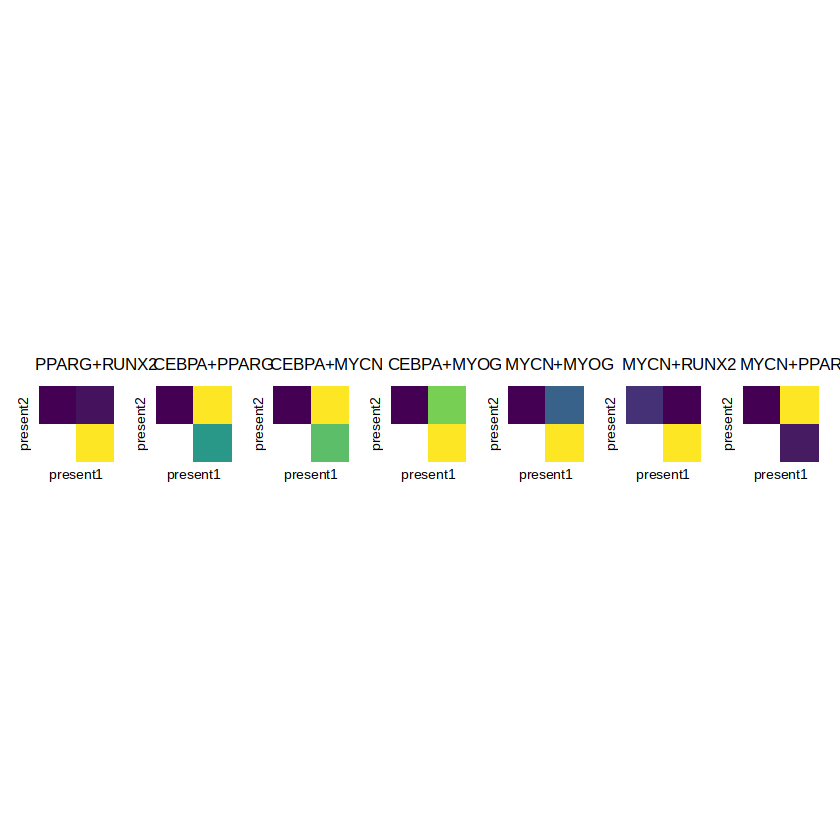

In [30]:
# no dose
plots <- map2(combinations, seu_diffexps, function(combination, seu_diffexp) {
  col <- sym("adiposcore1")
  
  seu_diffexp <- seu_diffexp[, seu_diffexp$Phase_corrected == "G1"]
  
  seu_diffexp@meta.data$present1 <- as.numeric(seu_diffexp@meta.data$bin1) > 1
  seu_diffexp@meta.data$present2 <- as.numeric(seu_diffexp@meta.data$bin2) > 1
  summarized <- seu_diffexp@meta.data %>% group_by(present1, present2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  summarized$score[summarized$n <= 1] = mean(summarized$score)
  
  title_1 <- paste0(combination[[2]], "+", combination[[1]])
  title_2 <- ifelse(
      summarized$score[4] == max(summarized$score),
      ifelse(
        (summarized$score[2] - summarized$score[1]) + (summarized$score[3] - summarized$score[1]) < (summarized$score[4] - summarized$score[1]),
        "synergistic",
        "subadditive"
      ), 
      "antagonistic"
    )
  title <- paste0(title_1, "\n", title_2)
  
  plot <- ggplot(summarized, aes(present1, present2, fill= score)) + 
    geom_tile() +
    # geom_text(aes(label = n)) +
    scale_fill_viridis_c(na.value = "#33333333") +
    ggtitle(title)
  plot %>% theme_heatmap(combination, legend = F) +    scale_x_discrete(breaks = NULL) +
    scale_y_discrete(breaks = NULL)
})
plot <- c(plots) %>% patchwork::wrap_plots(ncol = 7)
plot
ggsave(file.path(heatmap_folder, "adiposcore_nodose.png"), width = 7*4, height = 4)
file.path(heatmap_folder, "adiposcore_nodose.png")


Warning message:
“Removed 320 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 320 rows containing non-finite outside the scale range
(`stat_signif()`).”
Warning message:
“Removed 320 rows containing missing values or values outside the scale range
(`position_quasirandom()`).”
Warning message:
“Removed 364 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 364 rows containing non-finite outside the scale range
(`stat_signif()`).”
Warning message:
“Removed 364 rows containing missing values or values outside the scale range
(`position_quasirandom()`).”
Warning message:
“Removed 281 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 281 rows containing non-finite outside the scale range
(`stat_signif()`).”
Warning message:
“Removed 281 rows containing missing values or values outside the scale range
(`position_quasirandom()`).”
Warning message:
“R

[1] "/srv/data/wouters/projects/tfseq/code/ZZ_Combinations/output/adiposcore_nodose_significance.png"

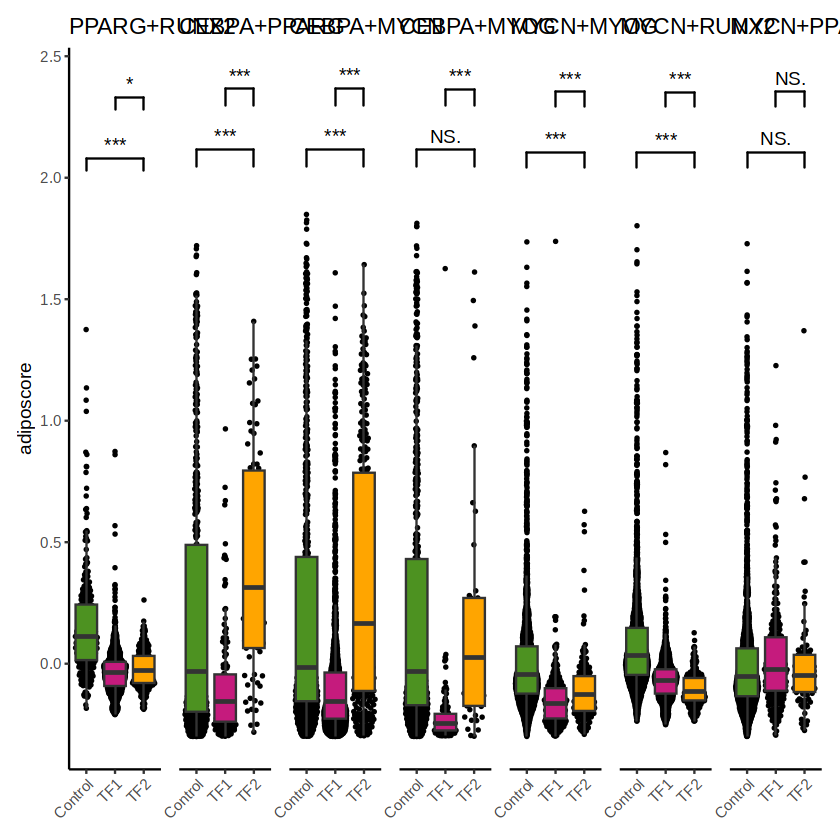

In [39]:

# no dose - boxplot
library(ggsignif)
plots <- pmap(list(seq(length(combinations)), combinations, seu_diffexps), function(combination_ix, combination, seu_diffexp) {
  col <- sym("adiposcore1")
  
  seu_diffexp <- seu_diffexp[, seu_diffexp$Phase_corrected == "G1"]
  
  plotdata <- seu_diffexp@meta.data
  
  conditions_oi <- levels(plotdata$condition)
  
  seu_diffexp@meta.data$present1 <- as.numeric(seu_diffexp@meta.data$bin1) > 1
  seu_diffexp@meta.data$present2 <- as.numeric(seu_diffexp@meta.data$bin2) > 1
  
  summarized <- seu_diffexp@meta.data %>% group_by(present1, present2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  summarized$score[summarized$n <= 1] = mean(summarized$score)
  
  title_1 <- paste0(toupper(combination[[1]]), "+", toupper(combination[[2]]))
  title_2 <- ""
  # title_2 <- ifelse(
  #   summarized$score[4] == max(summarized$score),
  #   ifelse(
  #     (summarized$score[2] - summarized$score[1]) + (summarized$score[3] - summarized$score[1]) < (summarized$score[4] - summarized$score[1]),
  #     "synergistic",
  #     "subadditive"
  #   ), 
  #   "antagonistic"
  # )
  title <- paste0(title_1)
  
  plot <- ggplot(plotdata, aes(condition, !!col)) + 
    ggbeeswarm::geom_quasirandom(aes(y = pmin(!!col, 2.0)), size = 0.5) +
    geom_boxplot(aes(fill = condition), outlier.alpha=0.) +
    ggsignif::geom_signif(
      comparisons = list(c(conditions_oi[[2]], conditions_oi[[4]]), c(conditions_oi[[3]], conditions_oi[[4]])),
      map_signif_level = c("***"=0.001, "**"=0.01, "*"=0.05),
      y_position = c(2.0, 2.25)
    ) +
    # scale_x_discrete(labels = c("mCherry", conditions_oi[2:3], paste0(combination[[1]], " +\n", combination[[2]])), name = NULL) +
    scale_x_discrete(labels = c("Control", "TF1", "TF2","TF1+TF2"), name = NULL) +
    scale_fill_manual(values = setNames(c(fourway_colors[1], fourway_colors[3], fourway_colors[2], "orange"), conditions_oi)) +
    ggtitle(title) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, hjust=1), legend.position = "none")
  
  if (combination_ix != 1) {
    plot <- plot + scale_y_continuous(name = NULL, breaks = NULL, limits = c(-0.3, 2.4))
  } else {
    plot <- plot + scale_y_continuous(name = "adiposcore", limits = c(-0.3, 2.4))
  }
  plot
})
plot <- c(plots) %>% patchwork::wrap_plots(ncol = 7)
plot
ggsave(file.path(plot_folder, "adiposcore_nodose_significance.png"), width = 12, height = 3.5)
ggsave(file.path(plot_folder, "adiposcore_nodose_significance.pdf"), width = 12, height = 3.5)
file.path(plot_folder, "adiposcore_nodose_significance.png")

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


[1] "/srv/data/wouters/projects/tfseq/code/ZZ_Combinations/singletf_interaction/heatmaps/proliferation.pdf"

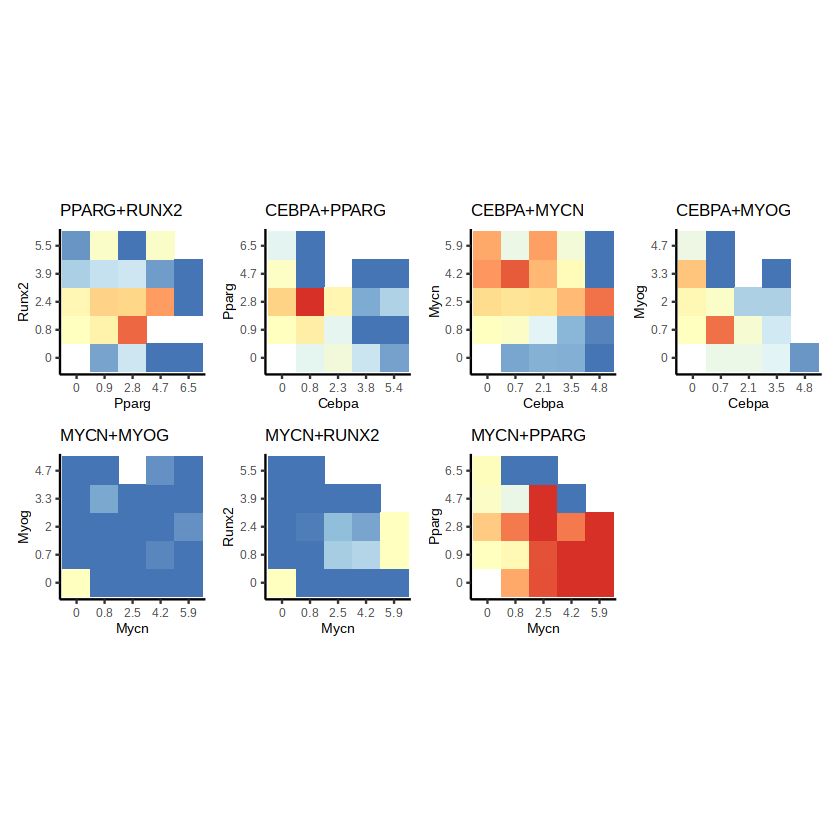

In [ ]:
## CELL CYCLE
plot_folder <- file.path("output/proliferation")
dir.create(plot_folder, recursive = TRUE, showWarnings = FALSE)

plots <- map2(combinations, seu_diffexps, function(combination, seu_diffexp) {
  seu_diffexp$proliferating <- seu_diffexp$Phase_corrected != "G1"
  col <- sym("proliferating")
  
  summarized <- seu_diffexp@meta.data %>% group_by(bin1, bin2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  # summarized$score[summarized$n <= 2] = summarized$score[1]
  title <- paste0(combination[[2]], "+", combination[[1]])
  
  average <- summarized$score[1]
  summarized$score <- log2((summarized$score + 0.1) / (average+0.1))
  
  plot <- ggplot(summarized, aes(bin1, bin2, fill= score)) + 
    geom_tile() +
    # geom_text(aes(label = n)) +
    scale_fill_distiller(palette = "RdYlBu", type = "div", limits = c(-1, 1.), oob = scales::oob_squish) +
    scale_x_discrete(labels = seu_diffexp@misc$bin_info1 %>% select(name, label) %>% deframe(), name = combination[[1]]) +
    scale_y_discrete(labels = seu_diffexp@misc$bin_info2 %>% select(name, label) %>% deframe(), name = combination[[2]]) +
    ggtitle(title)
  plot %>% theme_heatmap(combination, legend= F)
})
plot <- c(plots) %>% patchwork::wrap_plots(ncol = 4)
plot

plot <- ggplot(data.frame(x = c(0, 1), y = c(0, 1))) + 
  geom_point(aes(x = x, y = y, color = x)) + 
  scale_color_distiller(name = "% proliferating cells\nrelative to control", palette = "RdYlBu", type = "div", limits = c(-1, 1.), oob = scales::oob_squish, breaks = c(-1, 0, 1), labels = c("1/2", "1", "2"))

legend <- cowplot::get_legend(plot) # legend
plot <- c(plots, list(ggpubr::as_ggplot(legend))) %>% patchwork::wrap_plots(ncol = 4)

w = 2.5
ggsave(file.path(plot_folder, "proliferation.pdf"), width = w*4, height = w*2)
file.path(heatmap_folder, "proliferation.pdf")

`summarise()` has grouped output by 'binix1'. You can override using the
`.groups` argument.


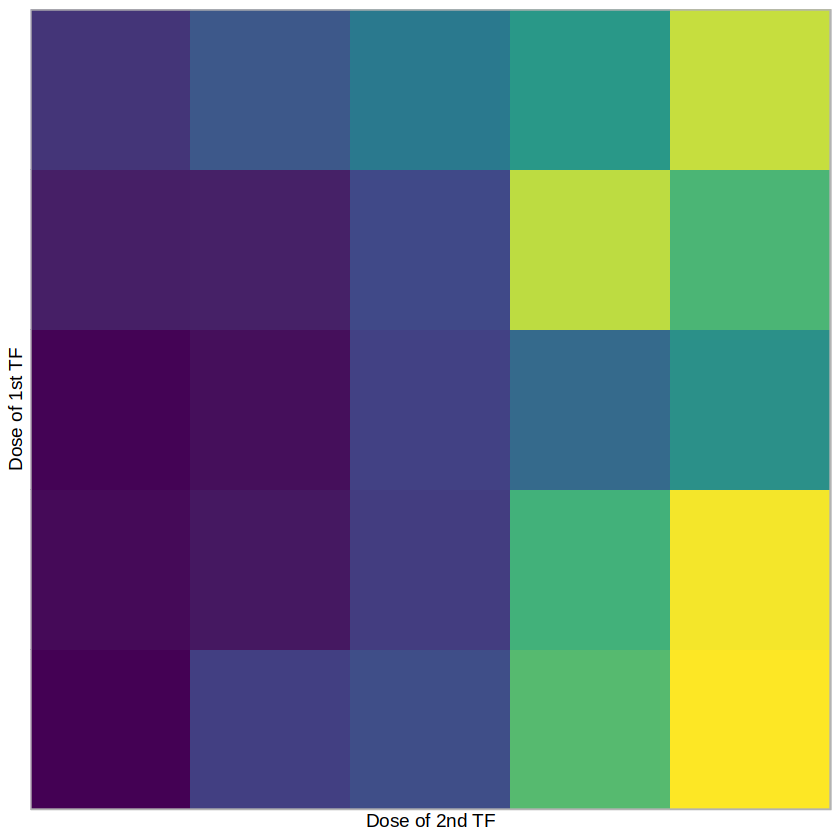

In [41]:
# all
summarizeds <- map_dfr(seu_diffexps, function(seu_diffexp) {
  col <- sym("adiposcore1")
  
  summarized <- seu_diffexp@meta.data %>% group_by(bin1, bin2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  summarized$binix1 <- as.numeric(summarized$bin1)
  summarized$binix2 <- as.numeric(summarized$bin2)
  summarized
})
summarized <- summarizeds %>% group_by(binix1, binix2) %>% dplyr::summarize(score = mean(score, na.rm = T)) %>% ungroup()

plot <- ggplot(summarized, aes(binix1, binix2, fill= score)) + 
  geom_tile() +
  scale_x_discrete(expand = c(0, 0), name = "Dose of 2nd TF") +
  scale_y_discrete(expand = c(0, 0), name = "Dose of 1st TF") +
  scale_fill_viridis_c(na.value = "#33333333") +
  coord_fixed() + 
  theme_light() +
  theme(legend.position="none") +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
plot



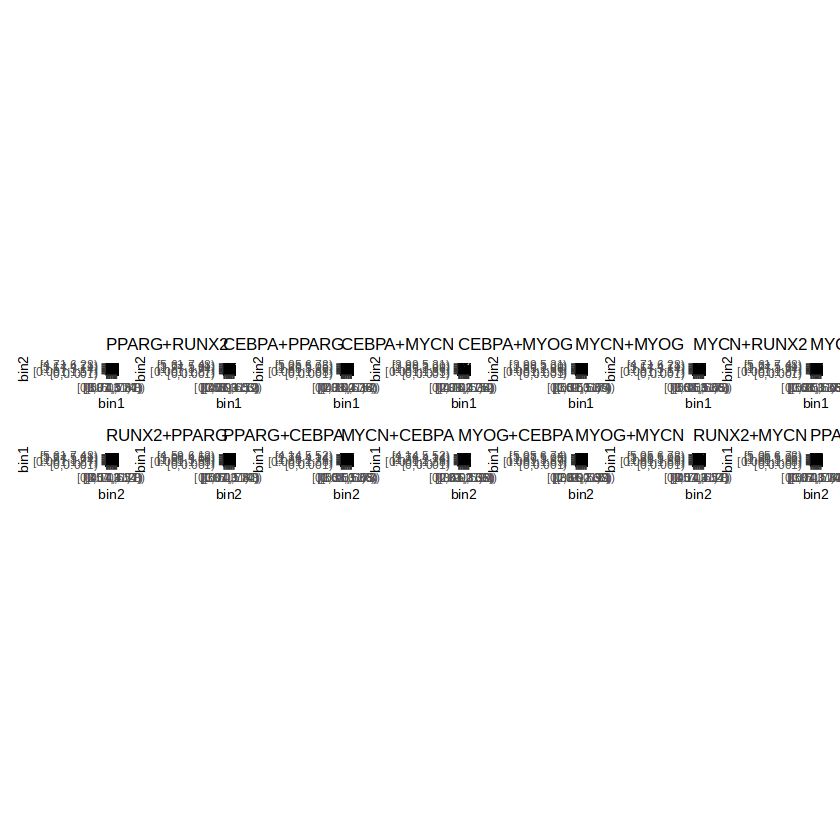

In [42]:

###
plots_left <- map2(combinations, seu_diffexps, function(combination, seu_diffexp) {
  col <- sym(paste0(combination[[2]], "1"))
  # col <- sym(paste0(combination[[1]], "_unique1"))
  
  summarized <- seu_diffexp@meta.data %>% group_by(bin1, bin2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  title <- paste0(combination[[2]], "->", combination[[1]])
  
  plot <- ggplot(summarized, aes(bin1, bin2, fill= score)) + 
    geom_tile() +
    geom_text(aes(label = n)) +
    scale_fill_viridis_c(na.value = "#33333333") +
    ggtitle(title)
  plot %>% theme_heatmap(combination, legend = F)
})
plots_right <- map2(combinations, seu_diffexps, function(combination, seu_diffexp) {
  col <- sym(paste0(combination[[1]], "1"))
  
  summarized <- seu_diffexp@meta.data %>% group_by(bin1, bin2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  title <- paste0(combination[[1]], "->", combination[[2]])
  
  plot <- ggplot(summarized, aes(bin2, bin1, fill= score)) + 
    geom_tile() +
    geom_text(aes(label = n)) +
    scale_fill_viridis_c(na.value = "#33333333") +
    ggtitle(title)
  plot %>% theme_heatmap(rev(combination), legend = F)
})

c(plots_left, plots_right) %>% patchwork::wrap_plots(ncol = 7)




## Unique

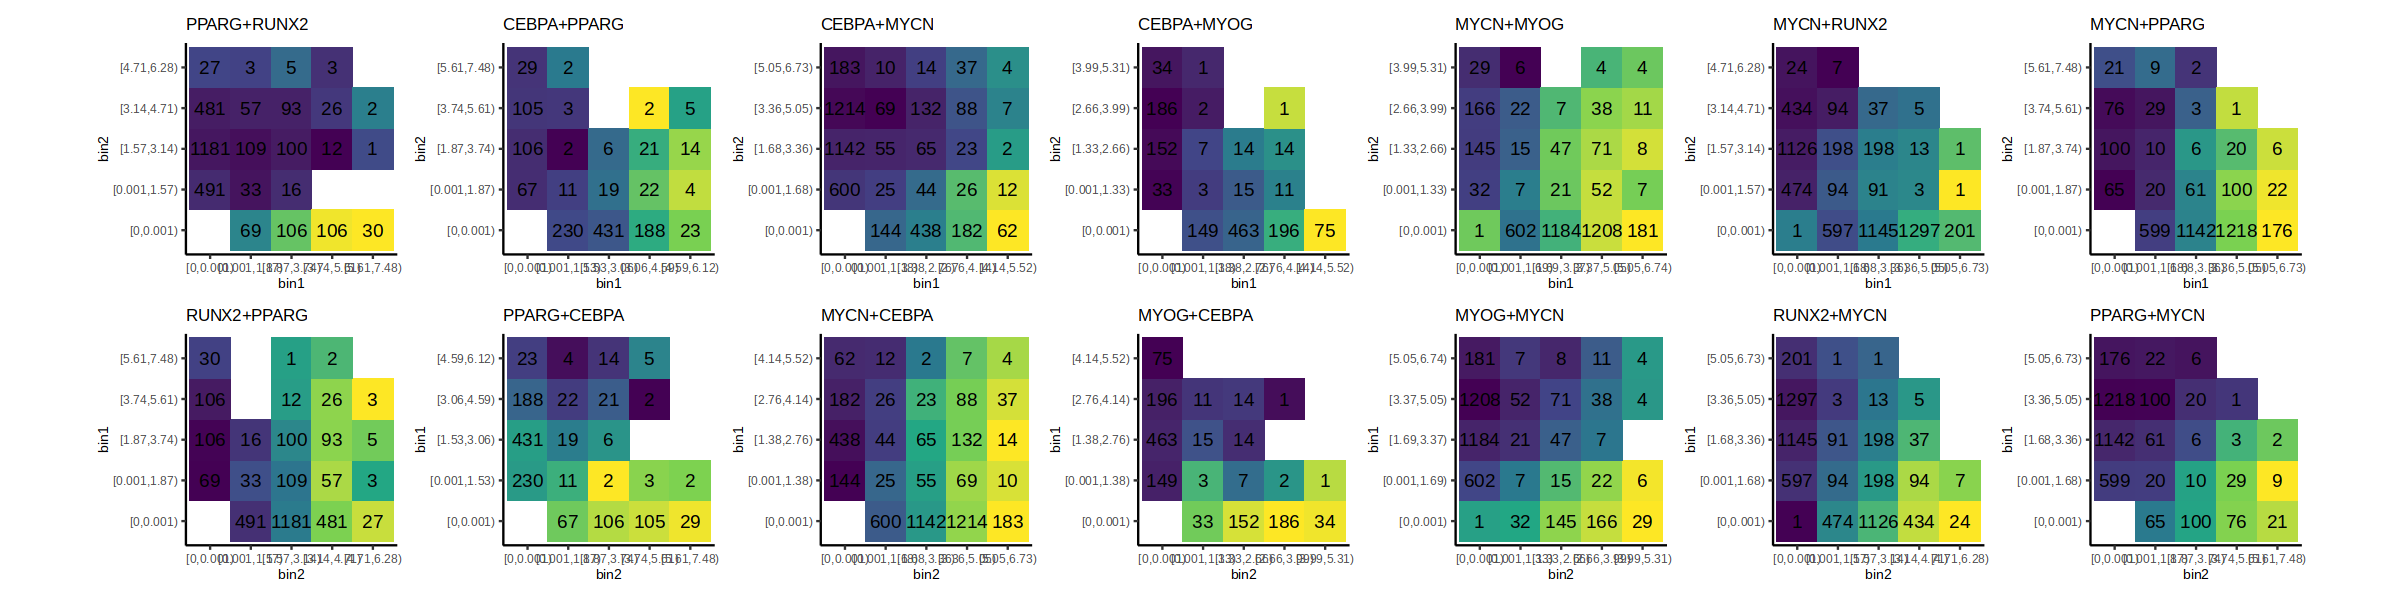

In [55]:
plots_left <- map2(combinations, seu_diffexps, function(combination, seu_diffexp) {
  # col <- sym(paste0(combination[[2]], "1"))
  col <- sym(paste0(combination[[2]], "_unique1"))
  
  summarized <- seu_diffexp@meta.data %>% group_by(bin1, bin2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  title <- paste0(combination[[2]], "->", combination[[1]])
  
  plot <- ggplot(summarized, aes(bin1, bin2, fill= score)) + 
    geom_tile() +
    geom_text(aes(label = n)) +
    scale_fill_viridis_c(na.value = "#33333333") +
    ggtitle(title)
  plot %>% theme_heatmap(combination, legend = F)
})
plots_right <- map2(combinations, seu_diffexps, function(combination, seu_diffexp) {
  # col <- sym(paste0(combination[[1]], "1"))
  col <- sym(paste0(combination[[1]], "_unique1"))
  
  summarized <- seu_diffexp@meta.data %>% group_by(bin1, bin2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  title <- paste0(combination[[1]], "->", combination[[2]])
  
  plot <- ggplot(summarized, aes(bin2, bin1, fill= score)) + 
    geom_tile() +
    geom_text(aes(label = n)) +
    scale_fill_viridis_c(na.value = "#33333333") +
    ggtitle(title)
  plot %>% theme_heatmap(rev(combination), legend = F)
})

options(repr.plot.width = 20, repr.plot.height = 5)

c(plots_left, plots_right) %>% patchwork::wrap_plots(ncol = 7)



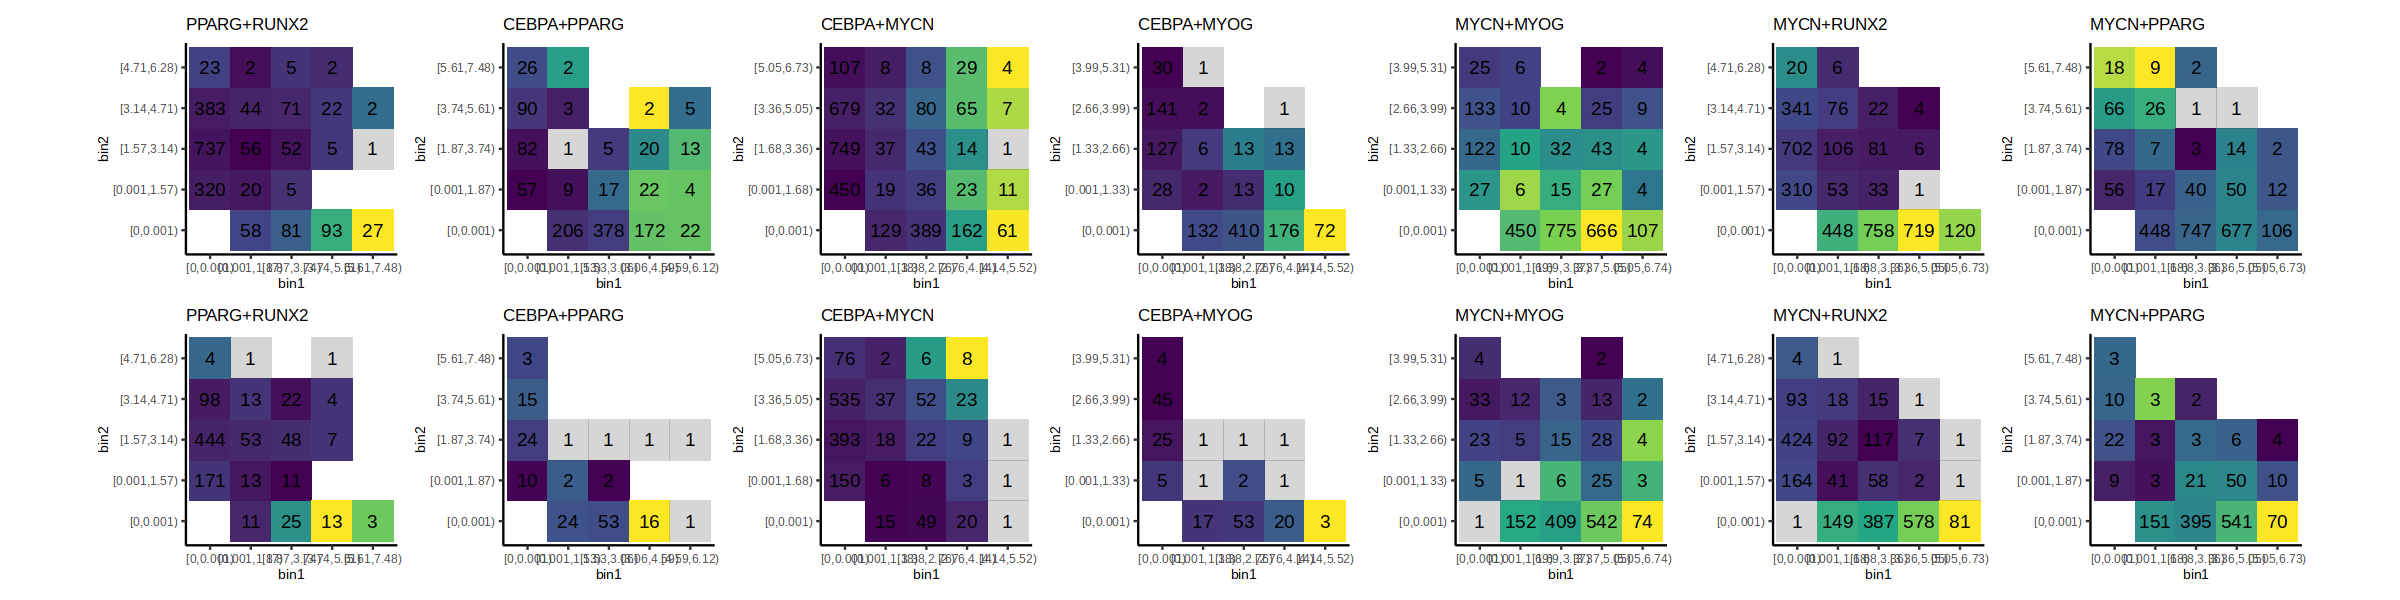

In [ ]:

## Adiposcore
plots_g1 <- map2(combinations, seu_diffexps, function(combination, seu_diffexp) {
  col <- sym("adiposcore1")
  seu_diffexp <- seu_diffexp[, seu_diffexp$Phase_corrected == "G1"]
  
  summarized <- seu_diffexp@meta.data %>% group_by(bin1, bin2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  n_cells_cutoff <- 2
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  title <- paste0(combination[[2]], "->", combination[[1]])
  
  plot <- ggplot(summarized, aes(bin1, bin2, fill= score)) + 
    geom_tile() +
    geom_text(aes(label = n)) +
    scale_fill_viridis_c(na.value = "#33333333") +
    ggtitle(title)
  plot %>% theme_heatmap(combination, legend = F)
})

plots_cc <- map2(combinations, seu_diffexps, function(combination, seu_diffexp) {
  col <- sym("adiposcore1")
  seu_diffexp <- seu_diffexp[, seu_diffexp$Phase_corrected != "G1"]
  
  summarized <- seu_diffexp@meta.data %>% group_by(bin1, bin2) %>% dplyr::summarize(score = mean(!!col), n = n(), .groups = "drop")
  n_cells_cutoff <- 2
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  title <- paste0(combination[[2]], "->", combination[[1]])
  
  plot <- ggplot(summarized, aes(bin1, bin2, fill= score)) + 
    geom_tile() +
    geom_text(aes(label = n)) +
    scale_fill_viridis_c(na.value = "#33333333") +
    ggtitle(title)
  plot %>% theme_heatmap(combination, legend = F)
})
c(plots_g1, plots_cc) %>% patchwork::wrap_plots(ncol = 7)


In [58]:



summarizeds <- map_dfr(seu_diffexps, function(seu_diffexp) {
  summarized <- seu_diffexp@meta.data
  summarized$binix1 <- as.numeric(summarized$bin1)
  summarized$binix2 <- as.numeric(summarized$bin1)
  summarized
})
summarized <- summarizeds %>% group_by(binix1, binix2) %>% dplyr::summarize(score = mean(score, na.rm = T))

plot <- ggplot(summarized, aes(bin2, bin1, fill= score)) + 
  geom_tile() +
  scale_x_discrete(expand = c(0, 0), name = "Dose of 2nd TF") +
  scale_y_discrete(expand = c(0, 0), name = "Dose of 1st TF") +
  scale_fill_viridis_c(na.value = "#33333333") +
  coord_fixed() + 
  theme_light() +
  theme(legend.position="none") +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
plot
ggsave(file.path(heatmap_folder, paste0("all-all", ".png")), plot, width = width, height = height)


ERROR: [1m[33mError[39m in `dplyr::summarize()`:[22m
[1m[22m[36mℹ[39m In argument: `score = mean(score, na.rm = T)`.
[36mℹ[39m In group 1: `binix1 = 1` and `binix2 = 1`.
[1mCaused by error:[22m
[33m![39m object 'score' not found
